#**Text-to-Image using DCGAN**

##**1.Data Preparing**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q torchfile

  Preparing metadata (setup.py) ... done


In [3]:
import os
import h5py
import torchfile
from glob import glob
import numpy as np

In [4]:
images_path = '/content/drive/MyDrive/Text to Image Synthesis using DCGAN/data'
embedding_path = '/content/drive/MyDrive/Text to Image Synthesis using DCGAN/data/flowers_icml'
text_path = '/content/drive/MyDrive/Text to Image Synthesis using DCGAN/data/cvpr2016_flowers/text_c10'
save_dataset_path = '/content/drive/MyDrive/Text to Image Synthesis using DCGAN/data/flowers.hdf5'

train_path = '/content/drive/MyDrive/Text to Image Synthesis using DCGAN/data/flowers_icml/trainclasses.txt'
val_path = '/content/drive/MyDrive/Text to Image Synthesis using DCGAN/data/flowers_icml/valclasses.txt'
test_path = '/content/drive/MyDrive/Text to Image Synthesis using DCGAN/data/flowers_icml/testclasses.txt'

In [5]:
train_classes = open(train_path).read().splitlines()
val_classes = open(val_path).read().splitlines()
test_classes = open(test_path).read().splitlines()

In [ ]:
import h5py

with h5py.File(save_dataset_path, 'w') as f:
    train = f.create_group('train')
    val = f.create_group('val')
    test = f.create_group('test')

    for _class in sorted(os.listdir(embedding_path)):
        split = ''
        if _class in train_classes:
            split = train
        elif _class in val_classes:
            split = val
        elif _class in test_classes:
            split = test

        data_path = os.path.join(embedding_path, _class)
        txt_path = os.path.join(text_path, _class)
        for example, txt_file in zip(sorted(glob(data_path + "/*.t7")), sorted(glob(txt_path + "/*.txt"))):
            example_data = torchfile.load(example)
            img_path = example_data[b'img'].decode("utf-8")
            embeddings = example_data[b'txt']
            example_name = img_path.split('/')[-1][:-4]

            with open(txt_file, "r") as f_txt:
                txt = f_txt.readlines()

            img_path = os.path.join(images_path, img_path)
            img = open(img_path, 'rb').read()

            print(example_name, txt)
            txt_choice = np.random.choice(range(10), 5)

            embeddings = embeddings[txt_choice]
            txt = np.array(txt)
            txt = txt[txt_choice]
            dt = h5py.special_dtype(vlen=str)

            for c, e in enumerate(embeddings):
                ex = split.create_group(example_name + '_' + str(c))
                ex.create_dataset('name', data=example_name)
                ex.create_dataset('img', data=np.void(img))
                ex.create_dataset('embeddings', data=e)
                ex.create_dataset('class', data=_class)
                ex.create_dataset('txt', data=txt[c].astype(object), dtype=dt)

            print(example_name, txt[1], _class)


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
image_01785 the petals of this flower are pink with a short stigma
 class_00083
image_01786 ['this bright red flower has an outer row of star-shaped petals and an inner trumpet-shaped row, and also a prominent yellow pistil\n', 'this flower is red and yellow in color, with petals that are wilted in appearance.\n', 'this flower has petals that are red with yellow stigma\n', 'an orange flower with bent petals and a long orange pollen tube.\n', 'this is a flower with red petals and a long red and yellow pistil.\n', 'this flower has large red petals with small yellow stamens and a red stigma\n', 'this flower is red in color, and has petals that are oval shaped and ruffled.\n', 'this flower has petals that are red and has a yellow style\n', 'this flower has bright red veined petals and a long red stamen and yellow anthers.\n', 'this flower has a tall red pistil and bright red petals.\n']
image_01786 this flower has petals that are red

In [ ]:
dataset = h5py.File('/content/drive/MyDrive/Text to Image Synthesis using DCGAN/data/flowers.hdf5', mode='r')

In [ ]:
dataset['train']['image_08189_4'].keys()

<KeysViewHDF5 ['class', 'embeddings', 'img', 'name', 'txt']>

##**2. Dataset**

In [6]:
import io
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class Text2ImageDataset(Dataset):

    def __init__(self, dataset_path, transform=None, split=0):
        self.dataset_path = dataset_path
        self.transform = transform
        self.dataset = h5py.File(self.dataset_path, mode='r')
        self.split = 'train' if split == 0 else 'val' if split == 1 else 'test'
        self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]
        self.h5py2int = lambda x: int(np.array(x))

    def __len__(self):
        length = len(self.dataset[self.split])
        return length

    def __getitem__(self, idx):
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]

        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))
        inter_embed = np.array(self.find_inter_embed())

        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))

        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        try:
            txt = np.array(example['txt']).astype(str)
        except:

            txt = np.array([example['txt'][()].decode('utf-8', errors='replace')])
            txt = np.char.replace(txt, '�', ' ').astype(str)

        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': torch.FloatTensor(right_embed),
                'wrong_images': torch.FloatTensor(wrong_image),
                'inter_embed': torch.FloatTensor(inter_embed),
                'txt': str(txt)
                 }

        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample

    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)

    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']


    def validate_image(self, img):
        img = np.array(img, dtype=float)
        return img.transpose(2, 0, 1)

In [7]:
train_dataset = Text2ImageDataset(save_dataset_path, split=0)
val_dataset = Text2ImageDataset(save_dataset_path, split=1)
test_dataset = Text2ImageDataset(save_dataset_path, split=2)

In [ ]:
next(iter(train_dataset))

{'right_images': tensor([[[-0.0745, -0.2706, -0.3255,  ..., -0.8980, -0.9059, -0.8745],
          [-0.0275, -0.1294, -0.1216,  ..., -0.8980, -0.9137, -0.8980],
          [-0.0980, -0.0353, -0.0118,  ..., -0.8980, -0.9137, -0.8902],
          ...,
          [-0.2235, -0.0980, -0.1216,  ..., -0.6078, -0.5216, -0.4353],
          [-0.1922, -0.1451,  0.2706,  ..., -0.6000, -0.4980, -0.4196],
          [-0.0118,  0.1059,  0.5059,  ..., -0.5843, -0.4980, -0.4510]],
 
         [[-0.1137, -0.2784, -0.2314,  ..., -0.8824, -0.8902, -0.8588],
          [-0.0118, -0.0902, -0.0667,  ..., -0.8824, -0.8980, -0.8824],
          [-0.0275,  0.0667,  0.0824,  ..., -0.8824, -0.8980, -0.8745],
          ...,
          [-0.1843, -0.1059, -0.1216,  ..., -0.7647, -0.7020, -0.6235],
          [-0.1294, -0.1451,  0.1922,  ..., -0.7569, -0.6706, -0.5922],
          [ 0.0667,  0.1059,  0.3569,  ..., -0.7333, -0.6549, -0.6000]],
 
         [[-0.3412, -0.6471, -0.7255,  ..., -0.9843, -0.9922, -0.9608],
          [-

In [ ]:
next(iter(train_dataset))['right_embed'].shape

torch.Size([1024])

In [8]:
from torch.utils.data import DataLoader

batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

##**3.Model**

In [9]:
import torch
import torch.nn as nn

# Generator model
class Generator(nn.Module):
    def __init__(self, channels, noise_dim=100, embed_dim=1024, embed_out_dim=128):
        super(Generator, self).__init__()
        self.channels = channels
        self.noise_dim = noise_dim
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        self.text_embedding = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_out_dim),
            nn.BatchNorm1d(self.embed_out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.noise_dim + self.embed_out_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, self.channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, text):
        text = self.text_embedding(text)
        text = text.view(text.shape[0], text.shape[1], 1, 1)
        z = torch.cat([text, noise], 1)
        return self.model(z)


# The Embedding model
class Embedding(nn.Module):
    def __init__(self, size_in, size_out):
        super(Embedding, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.BatchNorm1d(size_out),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x, text):
        embed_out = self.text_embedding(text)
        embed_out_resize = embed_out.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)  # Resize to match the discriminator input size
        out = torch.cat([x, embed_out_resize], 1)  # Concatenate text embedding with the input feature map
        return out


# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, channels, embed_dim=1024, embed_out_dim=128):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        self.model = nn.Sequential(
            nn.Conv2d(self.channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.text_embedding = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_out_dim),
            nn.BatchNorm1d(self.embed_out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.output = nn.Sequential(
            nn.Conv2d(512 + self.embed_out_dim, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, text):
        x_out = self.model(x)
        out = self.text_embedding(text)
        out = out.view(out.shape[0], out.shape[1], 1, 1)
        out = torch.cat([x_out, out.repeat(1, 1, x_out.shape[2], x_out.shape[3])], 1)
        return self.output(out).squeeze(), x_out

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
embed_dim = 1024
noise_dim = 100
embed_out_dim = 64
generator = Generator(
    channels=3, embed_dim=embed_dim, noise_dim=noise_dim, embed_out_dim=embed_out_dim
).to(device)
generator.apply(weights_init)

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(164, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fals

In [13]:
discriminator = Discriminator(
    channels=3, embed_dim=embed_dim, embed_out_dim=embed_out_dim
).to(device)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (text_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

##**4.Training**

In [14]:
# setting up Adam optimizer for Generator and Discriminator
learning_rate = 0.0002
optimizer_G = torch.optim.Adam(
    generator.parameters(), lr=learning_rate, betas=(0.5, 0.999)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999)
)

# loss functions
criterion = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [ ]:
len(train_loader)

15

In [ ]:
import time

num_epochs = 50
real_label = 1.
fake_label = 0.
l1_coef = 50
l2_coef = 100

D_losses = []
G_losses = []

for epoch in range(num_epochs):
    epoch_D_loss = []
    epoch_G_loss = []
    batch_time = time.time()

    for idx, batch in enumerate(train_loader):

        images = batch['right_images'].to(device)
        wrong_images = batch['wrong_images'].to(device)
        embeddings = batch['right_embed'].to(device)
        batch_size = images.size(0)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Clear gradients for the discriminator
        optimizer_D.zero_grad()

        # Generate random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Generate fake image batch with the generator
        fake_images = generator(noise, embeddings)

        # Forward pass real batch and calculate loss
        real_out, real_act = discriminator(images, embeddings)
        d_loss_real = criterion(real_out, torch.full_like(real_out, real_label, device=device))

        # Forward pass wrong batch and calculate loss
        wrong_out, wrong_act = discriminator(wrong_images, embeddings)
        d_loss_wrong = criterion(wrong_out, torch.full_like(wrong_out, fake_label, device=device))

        # Forward pass fake batch and calculate loss
        fake_out, fake_act = discriminator(fake_images.detach(), embeddings)
        d_loss_fake = criterion(fake_out, torch.full_like(fake_out, fake_label, device=device))

        # Compute total discriminator loss
        d_loss = d_loss_real + d_loss_wrong + d_loss_fake

        # Backpropagate the gradients
        d_loss.backward()

        # Update the discriminator
        optimizer_D.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Clear gradients for the generator
        optimizer_G.zero_grad()

        # Generate new random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Generate new fake images using Generator
        fake_images = generator(noise, embeddings)

        # Get discriminator output for the new fake images
        out_fake, act_fake = discriminator(fake_images, embeddings)

        # Get discriminator output for the real images
        out_real, act_real = discriminator(images, embeddings)

        # Calculate losses
        g_bce = criterion(out_fake, torch.full_like(out_fake, real_label, device=device))
        g_l1 = l1_coef * l1_loss(fake_images, images)
        g_l2 = l2_coef * l2_loss(torch.mean(act_fake, 0), torch.mean(act_real, 0).detach())

        # Compute total generator loss
        g_loss = g_bce + g_l1 + g_l2

        # Backpropagate the gradients
        g_loss.backward()

        # Update the generator
        optimizer_G.step()

        epoch_D_loss.append(d_loss.item())
        epoch_G_loss.append(g_loss.item())

    print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
        epoch+1, idx+1, len(train_loader),
        d_loss.mean().item(),
        g_loss.mean().item(),
        time.time() - batch_time)
    )
    D_losses.append(sum(epoch_D_loss)/len(epoch_D_loss))
    G_losses.append(sum(epoch_G_loss)/len(epoch_G_loss))

Epoch 1 [15/15] loss_D: 1.9302 loss_G: 33.7586 time: 412.07
Epoch 2 [15/15] loss_D: 2.5380 loss_G: 36.8098 time: 394.14
Epoch 3 [15/15] loss_D: 1.6957 loss_G: 27.5225 time: 392.72
Epoch 4 [15/15] loss_D: 3.6026 loss_G: 25.2741 time: 396.78
Epoch 5 [15/15] loss_D: 1.6714 loss_G: 24.2540 time: 391.66
Epoch 6 [15/15] loss_D: 1.8345 loss_G: 25.1324 time: 395.34
Epoch 7 [15/15] loss_D: 1.6745 loss_G: 23.4764 time: 398.30
Epoch 8 [15/15] loss_D: 1.7470 loss_G: 24.8776 time: 394.56
Epoch 9 [15/15] loss_D: 1.7386 loss_G: 23.3575 time: 398.93
Epoch 10 [15/15] loss_D: 1.8268 loss_G: 25.1132 time: 411.22
Epoch 11 [15/15] loss_D: 1.7055 loss_G: 23.7907 time: 412.41
Epoch 12 [15/15] loss_D: 1.6887 loss_G: 24.0090 time: 397.69
Epoch 13 [15/15] loss_D: 1.6709 loss_G: 24.7716 time: 393.03
Epoch 14 [15/15] loss_D: 1.9674 loss_G: 23.3442 time: 396.41
Epoch 15 [15/15] loss_D: 1.7401 loss_G: 24.1295 time: 395.30
Epoch 16 [15/15] loss_D: 1.7256 loss_G: 23.6263 time: 395.45
Epoch 17 [15/15] loss_D: 1.6999 l

In [ ]:
!mkdir save_model

In [ ]:
import os
import torch

model_save_path = '/content/drive/MyDrive/Text to Image Synthesis using DCGAN/save_model'

if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

torch.save(generator.state_dict(), os.path.join(model_save_path, 'generator.pth'))

torch.save(discriminator.state_dict(), os.path.join(model_save_path,'discriminator.pth'))


In [ ]:
model_save_path = '/content/drive/MyDrive/Text to Image Synthesis using DCGAN/save_model'

In [16]:
generator.load_state_dict(torch.load(os.path.join(model_save_path, 'generator.pth')))
discriminator.load_state_dict(torch.load(os.path.join(model_save_path,'discriminator.pth')))

<All keys matched successfully>

In [17]:
generator.eval()

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(164, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fals

In [18]:
generator

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(164, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fals

##**5.Prediction**

In [50]:
example = np.random.choice(test_dataset)

In [51]:
example

{'right_images': tensor([[[-0.8667, -0.9059, -0.9137,  ..., -0.7647, -0.7882, -0.8196],
          [-0.8667, -0.8980, -0.8431,  ..., -0.7882, -0.8196, -0.8039],
          [-0.9059, -0.8824, -0.7255,  ..., -0.8196, -0.8667, -0.8118],
          ...,
          [-0.6549, -0.6627, -0.7020,  ..., -0.5137, -0.4980, -0.6549],
          [-0.6392, -0.6392, -0.7098,  ..., -0.5373, -0.5529, -0.6549],
          [-0.6000, -0.6471, -0.6706,  ..., -0.5373, -0.6157, -0.6706]],
 
         [[-0.7020, -0.7804, -0.8275,  ..., -0.5843, -0.5922, -0.6235],
          [-0.7333, -0.8118, -0.7333,  ..., -0.5765, -0.6706, -0.6471],
          [-0.8196, -0.8275, -0.5843,  ..., -0.6549, -0.7412, -0.6235],
          ...,
          [-0.3333, -0.3725, -0.4275,  ..., -0.2235, -0.1451, -0.3255],
          [-0.3647, -0.3804, -0.4588,  ..., -0.3255, -0.2235, -0.3176],
          [-0.3255, -0.3882, -0.4275,  ..., -0.3412, -0.3098, -0.3647]],
 
         [[-0.9216, -0.9608, -0.9765,  ..., -0.7804, -0.8039, -0.8510],
          [-

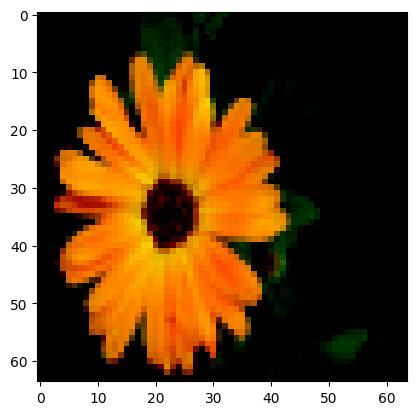

In [52]:
import matplotlib.pyplot as plt

plt.imshow(example['right_images'].permute(1, 2, 0))
plt.show()

In [155]:
embeddings = example['right_embed'].to(device)
noise = torch.randn(1, noise_dim, 1, 1, device=device)
pred = generator(noise, embeddings.unsqueeze(0))

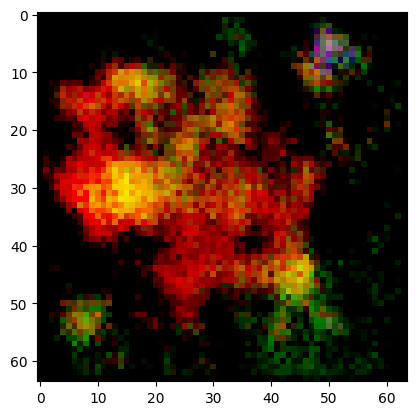

In [103]:
plt.imshow(pred[0].cpu().detach().permute(1, 2, 0))
plt.show()

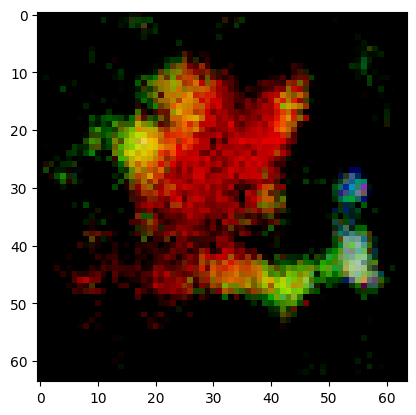

In [156]:
plt.imshow(pred[0].cpu().detach().permute(1, 2, 0))
plt.show()